In [1]:
%matplotlib inline

In [2]:
import numpy as np

'''
Helper functions to calculate adjoint, determinant and inverse of 2x2 covariance matrix
'''
def adj(a):
    '''
    Calculate adjoint of matrix a
    '''
    return np.array([[a[1,1], -1*a[0,1]],[-1*a[1,0],a[0,0]]])

def det(a):
    '''
    Calculate determinant of  matrix a
    '''
    return a[0,0]* a[1,1] - a[0,1] *  a[1,0]

def inv(a):
    '''
    Calculate inverse of matrix a
    '''
    if   det(a) != 0:
        invA = adj(a)/det(a)
        return invA
    else:
        raise Exception("Zero determinant, matrix not invertible")

#### The decision boundary equation for LDA can be given as follows:
$$w^Tx + c =0$$ 
where,
$$ w  =  \Sigma^{-1}(\mu_0 - \mu_1)$$
$$ c  =- \frac{1}{2} (\mu_0 + \mu_1)^T \Sigma^{-1} (\mu_0 - \mu_1) + \ln(P(w_0)) - \ln(P(w_1)) $$

In [3]:
class LDA():
    '''
    Linear Discriminant Analysis Class implementing fit, predict, predict_proba api.
    Finds the linear decision boundary equation to classify the data
    '''
    
    def _find_means(self,X,y):
        '''
        Compute mean of features for each class
        
        Parameters
        ----------
        X : array-like, shape = (n_samples, n_features)
            Input data.
        y : array-like, shape = (n_samples)
            Class values.
        
        Returns
        -------
        means : array-like, shape = (n_classes, n_features)
            Class means of each features.
        '''
        
        means = []
        # For each class, find the mean of each features.
        for c in self.classes_:
            # Get data belogning to class c
            Xc = X[y==c,:]
            # Get mean of each feature
            means.append(np.mean(Xc,axis=0))
        return np.asarray(means)
    
    def _find_covariance(self,X,y):
        '''
        Compute the weighted covariance matrix
        
        Parameters:
        -----------
        X : array-like, shape = (n_samples, n_features)
            Input data.
        y : array-like, shape = (n_samples)
            Class values.
        
        Returns
        -------
        covariance : array-like, shape = (n_features, n_features)
                    covariance matrix
        '''
        covariances = []
        for i,c in enumerate(self.classes_):
            # Get data belonging to class c
            Xc = X[y==c,:]
            # Center the data by subtracting the mean class value
            centered = Xc-self.means_[i]
            # Find the dot product 
            covariances.append(np.dot(centered.T, centered))
        # sum the covariances from each class and divide by (n_samples-n_features)
        covariance = np.sum(np.asarray(covariances),axis=0)/(self.n_samples-self.n_features)
        return covariance
    
    def get_coef(self):
        ''' 
        Find the coefficients for linear decision boundary
        
        Returns:
        --------
        x_coef :  array-like, shape = (n_features)
                linear coefficient for each features
                    
        intercept : scalar
                intercept value    
        '''
        # Get difference between means of each class
        diff_mean = self.means_[0] - self.means_[1]
        # Get sum of means for each class
        sum_mean = self.means_[0] + self.means_[1]
        # Calculate the linear coefficient vector
        x_coef  = self.covariance_inv @ diff_mean
        # Get the intercept value
        intercept = -0.5 * sum_mean @ self.covariance_inv @ diff_mean + np.log(self.priors_[0]) - np.log(self.priors_[1])
        return (x_coef, intercept)
    
    def fit(self, X,y):
        '''
        Find the coefficients for decision boundary according to given data
        
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training vector, where n_samples in the number of samples and
            n_features is the number of features.
            
        y : array, shape = [n_samples]
            Class values
        '''
        
        # Get total number of samples, and number of features from the training data
        self.n_samples, self.n_features = X.shape
        # Find the unique classes and class index for the training data
        self.classes_, class_indexes = np.unique(y, return_inverse = True)
        # Calculate prior probability
        self.priors_ =  np.bincount(class_indexes)/float(self.n_samples)
        # Get mean from training data for each class.
        self.means_ = self._find_means(X,y)
        # Get pooled covariance from training data
        self.covariance_ = self._find_covariance(X,y)
        # Get the inverse of the covariance matrix
        self.covariance_inv = inv(self.covariance_)
        # Get the parameters for linear decision boundary
        self.params_ =  self.get_coef()
        return self
    
    def log_prob_(self,X):
        probs = []
        for i in range(len(self.classes_)):
            Xd = X - self.means_[i]
            val =  -0.5 * (Xd *(self.covariance_inv@ Xd.T ).T).sum(-1)\
            + np.log(self.priors_[i])
            #- 0.5 * np.diag(Xd @ self.covariance_inv @ Xd.T) \
                  
            probs.append(val)
        d = np.asarray(probs).T
        return d
    
    def decision_boundary(self,X):
        '''
        Compute the value of decision boundary equation for each input
        
        Parmaters:
        ---------
        X :  array-like, shape = (n_samples, n_features)
            input data
        
        Returns:
        val: array-like, shape = (n_samples)
            output value after applying decison boudary equation
        '''
        
        val = X @ self.params_[0] + self.params_[1]
        return val
        
    def predict(self,X):
        '''
        Classify the given input
        
        Parmaters:
        ---------
        X :  array-like, shape = (n_samples, n_features)
            input data
        
        Returns:
        y_pred : array-like, shape = (n_samples)
                 class prediction value      
        '''
        
        # Apply the decision boundary equation to input
        d = self.decision_boundary(X)
        # Assign class according to whether decision boundary value is greater than 0 or not
        y_pred = np.where(d > 0 , self.classes_[0], self.classes_[1])
        return y_pred
    
    def predict_proba(self,X):
        '''
        Compute posterior probability for given X
        
        Parameters:
        ----------
        X : array-like, shape = (n_samples, n_features)
            Input data
        
        Returns:
        -------
        class probabilities, shape = (n_samples, n_classes)
        '''
        # Get the log probability of X 
        log_prob = self.log_prob_(X)
        # Take the exponential and divide by marginal probability
        return np.exp(log_prob)/ np.exp(log_prob).sum(axis=1)[:,np.newaxis]

#### The decision boundary equation for QDA can be given as follows:
$$x^T \mathbf{W} x + w^T x +c  = 0$$
where,
$$ \mathbf{W} = -\frac{1}{2}(\Sigma_0^{-1} -\Sigma_1^{-1})$$

$$ w = (\Sigma_0^{-1}\mu_0 -\Sigma_1^{-1}\mu_1) $$

$$ c =  \ln(P(w_0))- \ln(P(w_1)) -
\frac{1}{2}(\ln|\Sigma_0| - \ln|\Sigma_1| ) -\frac{1}{2}  \mu_0^T \Sigma_0^{-1}  \mu_0 +\frac{1}{2}  \mu_1^T \Sigma_1^{-1}  \mu_1$$

In [4]:
class QDA():
    '''
    Quadratic Discriminant Analysis Class implementing fit, predict, predict_proba api.
    Finds the quadratic decision boundary equation to classify the data
    '''
    
    def _find_means(self,X,y):
        '''
        Compute mean of features for each class
        
        Parameters
        ----------
        X : array-like, shape = (n_samples, n_features)
            Input data.
        y : array-like, shape = (n_samples)
            Class values.
        
        Returns
        -------
        means : array-like, shape = (n_classes, n_features)
            Class means of each features.
        '''
    
        means = []
        # For each class, find the mean of each features.
        for c in self.classes_:
            # Get data belogning to class c
            Xc = X[y==c,:]
            # Get mean of each feature
            means.append(np.mean(Xc,axis=0))
        return np.asarray(means)
    
    
    def _find_covariance(self,X,y):
        '''
        Compute the  covariance matrix of each class
        
        Parameters:
        -----------
        X : array-like, shape = (n_samples, n_features)
            Input data.
        y : array-like, shape = (n_samples)
            Class values.
        
        Returns
        -------
        covariances : list of array-like, shape = (n_features, n_features)
                    covariance matrix
        '''
        
        covariances = []
        for i,c in enumerate(self.classes_):
            # Get data belonging to class c
            Xc = X[y==c,:]
            # Center the data by subtracting the mean class value
            centered = Xc-self.means_[i]
            # Find the dot product and divide by (n_samples-1)
            covariances.append(np.dot(centered.T, centered)/(centered.shape[0]-1)) #unbiased
        return covariances
    
    def get_coef(self):
        ''' 
        Find the coefficients for quadratic decision boundary
        
        Returns:
        --------
        quad_coef : array-like, shape = (n_features, n_features)
                  coeffiecient for quadratic terms
        
        linear_coef :  array-like, shape = (n_features)
                 coefficient for linear terms
                    
        constant : scalar
                intercept value    
        '''
        # Calculate inverse of covariance matrix
        cov_inv0 = inv(self.covariance_[0])
        cov_inv1 = inv(self.covariance_[1])
        
        # Calculate determinant of covariance matrix
        cov_det0 = det(self.covariance_[0])
        cov_det1 = det(self.covariance_[1])
        
        # Calculate coefficient for quadratic terms
        quad_coef = -0.5 * (cov_inv0 - cov_inv1)
        
        # Calculate coefficient for linear coefficient
        linear_coef = cov_inv0@ self.means_[0] - cov_inv1@self.means_[1]
        
        # Calculate the constant value
        constant = np.log(self.priors_[0]) -np.log(self.priors_[1]) - 0.5 * (np.log(cov_det0) - np.log(cov_det1)\
                            + self.means_[0] @ cov_inv0 @ self.means_[0] - self.means_[1] @ cov_inv1 @ self.means_[1] )
        return quad_coef, linear_coef, constant
    
    
    def fit(self, X,y):
        '''
        Find the coefficients for decision boundary according to given data
        
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training vector, where n_samples in the number of samples and
            n_features is the number of features.
            
        y : array, shape = [n_samples]
            Class values
        '''
            
        # Get total number of samples, and number of features from the training data
        self.n_samples, self.n_features = X.shape
        # Find the unique classes and class index for the training data
        self.classes_, class_indexes = np.unique(y, return_inverse = True)
        # Calculate prior probability
        self.priors_ =  np.bincount(class_indexes)/float(self.n_samples)
        # Get mean from training data for each class.
        self.means_ = self._find_means(X,y)
        # Get covariance from training data for each class
        self.covariance_ = self._find_covariance(X,y)
        # Get the parameters for quadratic decision boundary
        self.params_ = self.get_coef()
        return self
    
    def decision_boundary(self,X):
        '''
        Compute the value of decision boundary equation for each input
        
        Parmaters:
        ---------
        X :  array-like, shape = (n_samples, n_features)
            input data
        
        Returns:
        val: array-like, shape = (n_samples)
            output value after applying decison boudary equation
        '''
        
        val = np.diag(X@self.params_[0]@X.T) + X @ self.params_[1] + self.params_[2]
        return val
    
    def log_prob_(self,X):
        probs = []
        for i in range(len(self.classes_)):
            Xd =  X - self.means_[i]
            covariance_inv = inv(self.covariance_[i])
             #- 0.5 * np.diag(Xd @ covariance_inv @ Xd.T) 
            val =  -0.5 * (Xd *(covariance_inv@ Xd.T ).T).sum(-1)\
                  - 0.5 * np.log(det(self.covariance_[i])) \
                  + np.log(self.priors_[i])
            probs.append(val)
        d = np.asarray(probs).T
        return d
       
    def predict(self,X):
        '''
        Classify the given input
        
        Parmaters:
        ---------
        X :  array-like, shape = (n_samples, n_features)
            input data
        
        Returns:
        y_pred : array-like, shape = (n_samples)
                 class prediction value      
        '''
        
        # Apply the decision boundary equation to input
        d = self.decision_boundary(X)
        # Assign class according to whether decision boundary value is greater than 0 or not
        y_pred = np.where(d > 0 , self.classes_[0], self.classes_[1])
        return y_pred
    
    def predict_proba(self,X):
        '''
        Compute posterior probability for given X
        
        Parameters:
        ----------
        X : array-like, shape = (n_samples, n_features)
            Input data
        
        Returns:
        -------
        class probabilities, shape = (n_samples, n_classes)
        '''
        
        log_prob = self.log_prob_(X)
        return np.exp(log_prob)/ np.exp(log_prob).sum(axis=1)[:,np.newaxis]
       


# Linear and Quadratic Discriminant Analysis with covariance ellipsoid

This example plots the covariance ellipsoids of each class and
decision boundary learned by LDA and QDA. The ellipsoids display
the double standard deviation for each class. With LDA, the
standard deviation is the same for all the classes, while each
class has its own standard deviation with QDA.


## Colormap



In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)

## Datasets generation functions



In [6]:
import numpy as np


def dataset_fixed_cov():
    """Generate 2 Gaussians samples with the same covariance matrix"""
    n, dim = 300, 2
    np.random.seed(105)
    C = np.array([[0.0, -0.23], [0.83, 0.23]])
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C) + np.array([1, 1]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    """Generate 2 Gaussians samples with different covariance matrices"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -1.0], [2.5, 0.7]]) * 2.0
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

## Plot functions



In [7]:
from scipy import linalg


def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
        plt.ylabel("Data with\n fixed covariance")
    elif fig_index == 2:
        plt.title("Quadratic Discriminant Analysis")
    elif fig_index == 3:
        plt.ylabel("Data with\n varying covariances")

    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")

## Plot



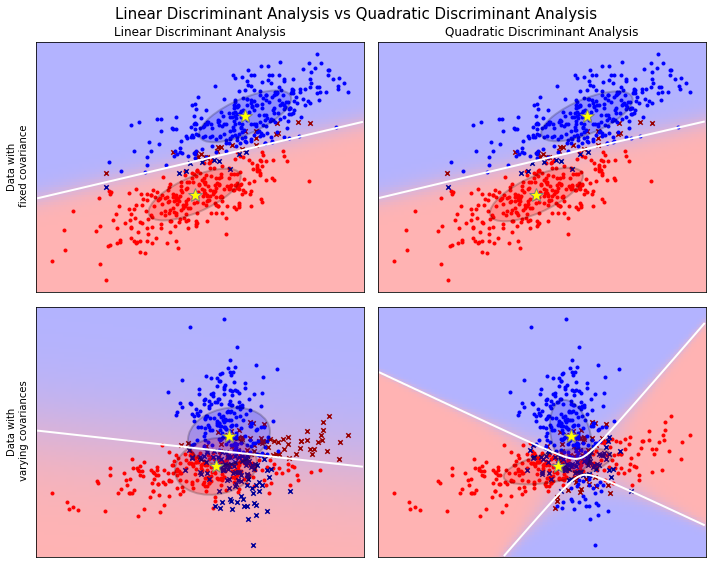

In [8]:
plt.figure(figsize=(10, 8), facecolor="white")
plt.suptitle(
    "Linear Discriminant Analysis vs Quadratic Discriminant Analysis",
    y=0.98,
    fontsize=15,
)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    #lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    # Use LDA class instead of sklearn's class
    lda = LDA()
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis("tight")

    # Quadratic Discriminant Analysis
    #qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    # Use QDA class instead of sklearn's class
    qda = QDA()
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis("tight")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()